<a href="https://colab.research.google.com/github/adamzki99/nlp-zlatan/blob/main/nlp_zlatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia

/content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia


# Reading the dataset

In [9]:
import json

with open('data.json', 'r') as file:
    json_data = file.read()
    data = json.loads(json_data)

print('Datatype:', type(data))

Datatype: <class 'list'>


# Data exploration


In [10]:
len(data)

22311

In [11]:
data[:5]

[{'chosen_topic': 'Science fiction',
  'persona': 'i enjoy movies about aliens invading the earth.',
  'wizard_eval': 5,
  'dialog': [{'speaker': '0_Wizard',
    'text': "I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.",
    'checked_sentence': {'chosen_Science_fiction_0': 'Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.'},
    'checked_passage': {'chosen_topic_0_Science_fiction': 'Science fiction'},
    'retrieved_passages': [{'Hyperspace (science fiction)': ['Hyperspace is a faster-than-light (FTL) method of traveling used in science fiction.',
       'It is typically described as an alternative "sub-region" of space co-existing with our own universe which may be 

In [12]:
data[0].keys()

dict_keys(['chosen_topic', 'persona', 'wizard_eval', 'dialog', 'chosen_topic_passage'])

In [13]:
data[0]['chosen_topic_passage']

['Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.',
 'Science fiction often explores the potential consequences of scientific and other innovations, and has been called a "literature of ideas".',
 'It usually avoids the supernatural, unlike the related genre of fantasy.',
 'Historically, science-fiction stories have had a grounding in actual science, but now this is only expected of hard science fiction.',
 'Science fiction is difficult to define, as it includes a wide range of subgenres and themes.',
 'Hugo Gernsback, who suggested the term "scientifiction" for his "Amazing Stories" magazine, wrote: "By \'scientifiction\' I mean the Jules Verne, H. G. Wells and Edgar Allan Poe type of story—a charming romance intermingled with scientific fact and prophetic vision..

In [14]:
data[0].keys()

dict_keys(['chosen_topic', 'persona', 'wizard_eval', 'dialog', 'chosen_topic_passage'])

In [15]:
print(data[0]['persona'])
print(data[0]['chosen_topic'])

i enjoy movies about aliens invading the earth.
Science fiction


Dictionary keys of Wizard

In [16]:
data[0]['dialog'][0].keys()

dict_keys(['speaker', 'text', 'checked_sentence', 'checked_passage', 'retrieved_passages', 'retrieved_topics'])

Dictionary keys of Apprentice

In [17]:
data[0]['dialog'][1].keys()

dict_keys(['speaker', 'text', 'retrieved_passages', 'retrieved_topics'])

In [18]:
for i in range(10):
    print(i, ":", data[0]['dialog'][i]['text'])

0 : I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.
1 : I'm a huge fan of science fiction myself! 
2 : Awesome! I really love how sci-fi storytellers focus on political/social/philosophical issues that would still be around even in the future. Makes them relatable.
3 : I agree. One of my favorite forms of science fiction is anything related to time travel! I find it fascinating.
4 : It's not quite sci-fi, but my favorite version of time travel is in Harry Potter and the Prisoner of Azkaban. Breaks zero logical rules.
5 : And that's difficult to do when dealing with time travel. I actually haven't seen the latest Harry Potter movies. Guess it's time to check them out!
6 : If you really want a look at the potential negative consequences of scientific innovation, what you should check out is the TV show Fringe. Incredibly well written.
7 : Thank you for the suggestion, I will definitely c

In [19]:
for i in range(10):
    print(i, ":", data[0]['dialog'][i]['retrieved_topics'])

0 : ['Hyperspace (science fiction)', 'Science fiction', 'History of science fiction', 'Science fiction film', 'Time travel', 'List of starships in Stargate', 'History of US science fiction and fantasy magazines to 1950']
1 : ['Science fiction', 'History of science fiction', 'Isaac Asimov', 'U.S. television science fiction', 'History of US science fiction and fantasy magazines to 1950', 'Starstruck (comics)', 'LGBT themes in speculative fiction']
2 : ['Oddworld Inhabitants', 'Legalism (Chinese philosophy)', 'Sci-Fi on the Rock', 'Starstruck (comics)', 'The Spirit of the Age', 'Science fiction film', 'Music of the Marvel Cinematic Universe']
3 : ['Science fiction', 'Science fiction film', 'History of science fiction', 'Time travel', 'Parallel universes in fiction', 'Alternate history', 'Time travel in fiction']
4 : ['Magical objects in Harry Potter', 'List of supporting Harry Potter characters', 'Harry Potter', 'Order of the Phoenix (fictional organisation)', 'Places in Harry Potter', 'M

In [20]:
for i in range(10):
    print(i, ":", data[0]['dialog'][i]['retrieved_passages'])

0 : [{'Hyperspace (science fiction)': ['Hyperspace is a faster-than-light (FTL) method of traveling used in science fiction.', 'It is typically described as an alternative "sub-region" of space co-existing with our own universe which may be entered using an energy field or other device.', 'As seen in most fiction hyperspace is most succinctly described as a "somewhere else" within which the laws of general and special relativity decidedly do "not" apply – especially with respect to the speed of light being the cosmic speed limit.', 'Entering and exiting said "elsewhere" thus directly enables travel near or faster than the speed of light – almost universally with the aid of extremely advanced technology.']}, {'Science fiction': ['Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrest

## Exploring uniqe types

Exploring how many uniqe "chosen_topic"s, "persona"s and "wizard_eval"s there are in the dataset

In [21]:
topics = []
personas = []
wizardEvals = []

for entry in data:

  topics.append(entry['chosen_topic'])
  personas.append(entry['persona'])
  wizardEvals.append(entry['wizard_eval'])

# Making the list containing only uniqe items
topics = list(set(topics))
personas = list(set(personas))
wizardEvals = list(set(wizardEvals))

print("topic:", len(topics), "persona:", len(personas), "wizard_eval:", len(wizardEvals))

topic: 1365 persona: 1557 wizard_eval: 7


Why are there more than 5 different "wizard_eval"s? The paper only mentions a rating from 1-5. What are the other 2?

In [22]:
for entry in wizardEvals:
  print(wizardEvals[entry] )
#what's up with -1 and 0? In paper only ratings from 1 to 5 are mentioned

0
1
2
3
4
5
-1


How often does each rating occur in "wizard_eval"s? Visualize all the different instances in a histogram

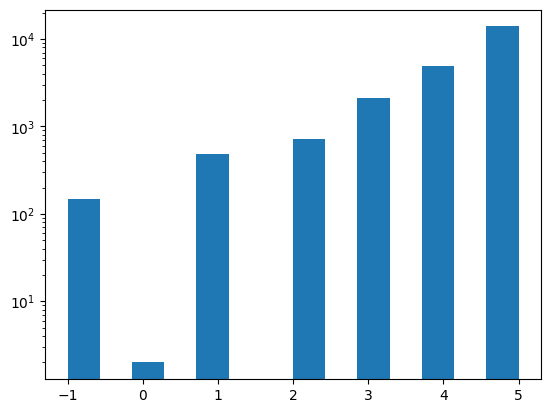

In [23]:
import matplotlib.pyplot as plt
import numpy as np

wEval = []

for entry in data:
    wEval.append(entry['wizard_eval'])

plt.hist(wEval, bins=2*len(set(wEval))) #this can probably be improved to look nicer
plt.yscale('log')
plt.show()

In [24]:
# What is a topic?

topics[:10]

['Kale',
 'Bengal cat',
 'Phonograph record',
 'Paris',
 'Shellfish',
 'Grand Slam (tennis)',
 'Snapple',
 'Brewery',
 'Broken heart',
 'Motorcycle']

In [25]:
# What is a persona?

personas[:10]

['rita hayworth is the woman of my dreams.',
 'my favorite food is pasta.',
 'i have 10 alpacas.',
 'i drive a honda civic.',
 'we liked to pretend we were superheroes.',
 'i am currently looking for a job.',
 'i like to watch japanese cartoons anime in my free time.',
 'i m the oldest of three boys.',
 'i am a professional skittles player.',
 'i have amazing eye sight.']

## Open question 1

Maybe there is some relation between topics and personas that we might be able to cluster in order to get som further insight?

##Trying to cluster (Farid)

###Data preprocessing

Preprocess data before clustering 

Combining chosen_topic and chosen_topic_passage (basically the Wiki article) to try to cluster them afterwards 

In [35]:
topics = [f"{sample['chosen_topic']}\n\n" + "\n".join([f"{passage}" for passage in sample['chosen_topic_passage']]) for sample in data]

In [34]:
print(topics[0])

Science fiction

Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.
Science fiction often explores the potential consequences of scientific and other innovations, and has been called a "literature of ideas".
It usually avoids the supernatural, unlike the related genre of fantasy.
Historically, science-fiction stories have had a grounding in actual science, but now this is only expected of hard science fiction.
Science fiction is difficult to define, as it includes a wide range of subgenres and themes.
Hugo Gernsback, who suggested the term "scientifiction" for his "Amazing Stories" magazine, wrote: "By 'scientifiction' I mean the Jules Verne, H. G. Wells and Edgar Allan Poe type of story—a charming romance intermingled with scientific fact and prophetic vision... Not o

###Vectorization of topics

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

Fitting the vectorizer to the data

In [43]:
vectorizer.fit(topics)

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

Size of Vocabulary

In [44]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 21015


Random sampling from Vocabulary

In [47]:
import random

sorted(random.sample(vocab.tolist(),20))

['adelines',
 'buell',
 'calling',
 'circles',
 'coalition',
 'compulsively',
 'congenital',
 'gaylord',
 'jumbo',
 'lesbians',
 'mushroom',
 'nordic',
 'nucleosynthesis',
 'obesity',
 'relation',
 'rhazes',
 'sponsored',
 'virility',
 'weightlifting',
 'wrote']

Vectorization of topics

In [48]:
vector_topics = vectorizer.transform(topics)

TF-IDF values of first topic

In [49]:
sorted([(vocab[j], vector_topics[0, j]) for j in vector_topics[0].nonzero()[1]], key=lambda x: -x[1])

[('fiction', 0.4380346930687953),
 ('science', 0.4210446737339226),
 ('scientifiction', 0.28080568828805436),
 ('travel', 0.20476450198299528),
 ('amazing', 0.17828441636247405),
 ('stories', 0.12902690274704126),
 ('scientific', 0.12726668815245748),
 ('genre', 0.11143305702346777),
 ('verne', 0.09360189609601811),
 ('universes', 0.09360189609601811),
 ('tremendously', 0.09360189609601811),
 ('sf', 0.09360189609601811),
 ('prophetic', 0.09360189609601811),
 ('intermingled', 0.09360189609601811),
 ('instructive', 0.09360189609601811),
 ('gernsback', 0.09360189609601811),
 ('pictured', 0.0923317092015762),
 ('imaginative', 0.0923317092015762),
 ('hugo', 0.09117716116629622),
 ('grounding', 0.09117716116629622),
 ('realization', 0.09011894207156375),
 ('sci', 0.0896211811372771),
 ('explores', 0.08914220818123703),
 ('avoids', 0.08868065633567133),
 ('jules', 0.08759527074397046),
 ('charming', 0.08759527074397046),
 ('extraterrestrial', 0.08738890396962107),
 ('innovations', 0.087185839

###Minibatch k-means

In [51]:
from sklearn.cluster import MiniBatchKMeans

####Elbow method to find number of clusters k

Generate the performance evaluation measure values across the range of k values -> Decrease k to around 50 to run faster

In [55]:
performance = [MiniBatchKMeans(n_clusters=k, batch_size=500, random_state=2307).fit(vector_topics).inertia_ for k in range(1,100)]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Use some standard code to plot the performance measure against the value k

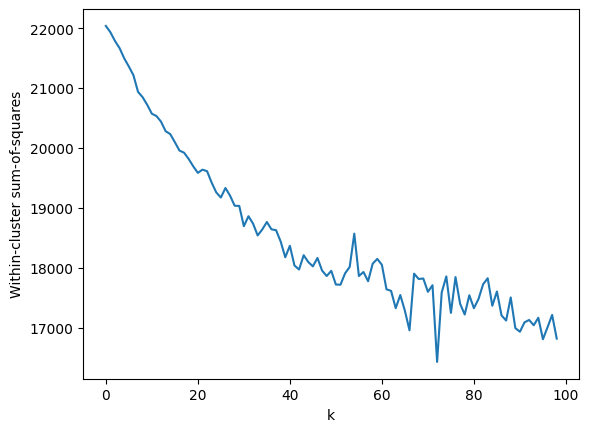

In [56]:
plt.figure()
plt.plot(performance)
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.show()

According to tutorial 4: "In theory it should always increase since the more cluster centroids there are, the more flexibility the model has for describing datapoints (assigning them to clusters)"

So something is probably wrong

# Retrieval-based response chatbot

This implementation aims to create a retrieval-based responce chatbot to provide the correct awnser to a given passage. This is done by taking all the correct awnsers, generating embeddings with them and then performing a "search" in the created vector space to find the passage that has the closest match with the given passage

## Data extraction

Extracts user prompts and wizard responses from a list of dialogues and stores them in separate lists based on the condition that the dialogue speaker is the wizard and the order in which they appear in the dialogue.

Here we also concatenate the strings with some extra information, like the chosen topic, in order to increase the precision of the search later. This is a valid approach and can be seen as that we are just adding more context to the passage.

In [36]:
#sets of documents
user_query = []
wizard_responses = []

chosen_topic = ""

for dialogue in data:

  if not 'Wizard' in dialogue['dialog'][0]['speaker']:
      continue

  chosen_topic = dialogue['chosen_topic']

  user_query.append(chosen_topic + " " + dialogue['persona'])

  for i, prompt in enumerate(dialogue['dialog']):

    if i % 2 == 0:
      wizard_responses.append(chosen_topic + " " + prompt['text'])
    else:
      user_query.append(chosen_topic + " " + prompt['text'])

## Document vectorization

In [37]:
# TfidfVectorizer 
# CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [38]:
# instantiate the vectorizer object
#countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words= 'english')

In [39]:
# convert th documents into a matrix
#count_wm = countvectorizer.fit_transform(train)
query_wm = tfidfvectorizer.fit_transform(user_query)
response_wm = tfidfvectorizer.fit_transform(wizard_responses)

In [40]:
# retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer) , it will give same output of get_feature_names() methods)
query_tokens = tfidfvectorizer.get_feature_names_out(query_wm)
responce_tokens = tfidfvectorizer.get_feature_names_out(response_wm)

## Verification

Some output in order to quickly verify the embeddings

In [41]:
responce_vectors = tfidfvectorizer.transform(wizard_responses)
query_vectors = tfidfvectorizer.transform(user_query)

print('responce_vectors:\n', responce_vectors)

print('query_vectors:\n', query_vectors)

responce_vectors:
   (0, 26647)	0.4025624814041743
  (0, 26244)	0.13780637913063432
  (0, 26093)	0.1231447547438451
  (0, 25787)	0.20611644821893715
  (0, 22769)	0.5414604936480512
  (0, 13721)	0.15960661269545903
  (0, 11244)	0.19864926395412064
  (0, 10999)	0.22874109035554913
  (0, 10932)	0.33671463799133616
  (0, 10217)	0.36754004972054594
  (0, 6135)	0.2670645458465244
  (0, 1704)	0.176296820364432
  (1, 24811)	0.3823355573183814
  (1, 23978)	0.20052646294568013
  (1, 22769)	0.2049406987865496
  (1, 22767)	0.2739020915518576
  (1, 21509)	0.3446015306784428
  (1, 21167)	0.13635538921767992
  (1, 19804)	0.25785035109248816
  (1, 19393)	0.30883072357717145
  (1, 15793)	0.19533062017173364
  (1, 15568)	0.12235789949133123
  (1, 14010)	0.2359253289813129
  (1, 10999)	0.2597328491105082
  (1, 10544)	0.2469540815527873
  :	:
  (50243, 1007)	0.3448900631505381
  (50243, 20)	0.311228305193144
  (50244, 27384)	0.19550203155375143
  (50244, 26244)	0.19745091961766895
  (50244, 24233)	0.40856

In [42]:
sorted([(query_tokens[j], query_vectors[0, j]) for j in query_vectors[0].nonzero()[1]], key=lambda x: -x[1])

[('invading', 0.5593147674151207),
 ('aliens', 0.4489133259076631),
 ('earth', 0.3584217292371375),
 ('movies', 0.31897291613933515),
 ('fiction', 0.3052593416364608),
 ('science', 0.29980564737335885),
 ('enjoy', 0.2690116497492894)]

## Search the vector space

Here we calculate the closest neighbor to the embedding of the query, and hopefully that is the "correct" passage we are looking for.

In [43]:
import numpy as np

query = 'Gardening: i like to garden.'

query_vec = tfidfvectorizer.transform([query])[0]

index = np.argmax([query_vec.multiply(vector_documents[i]).sum() for i in range(len(train))])
print(train[index])

NameError: ignored